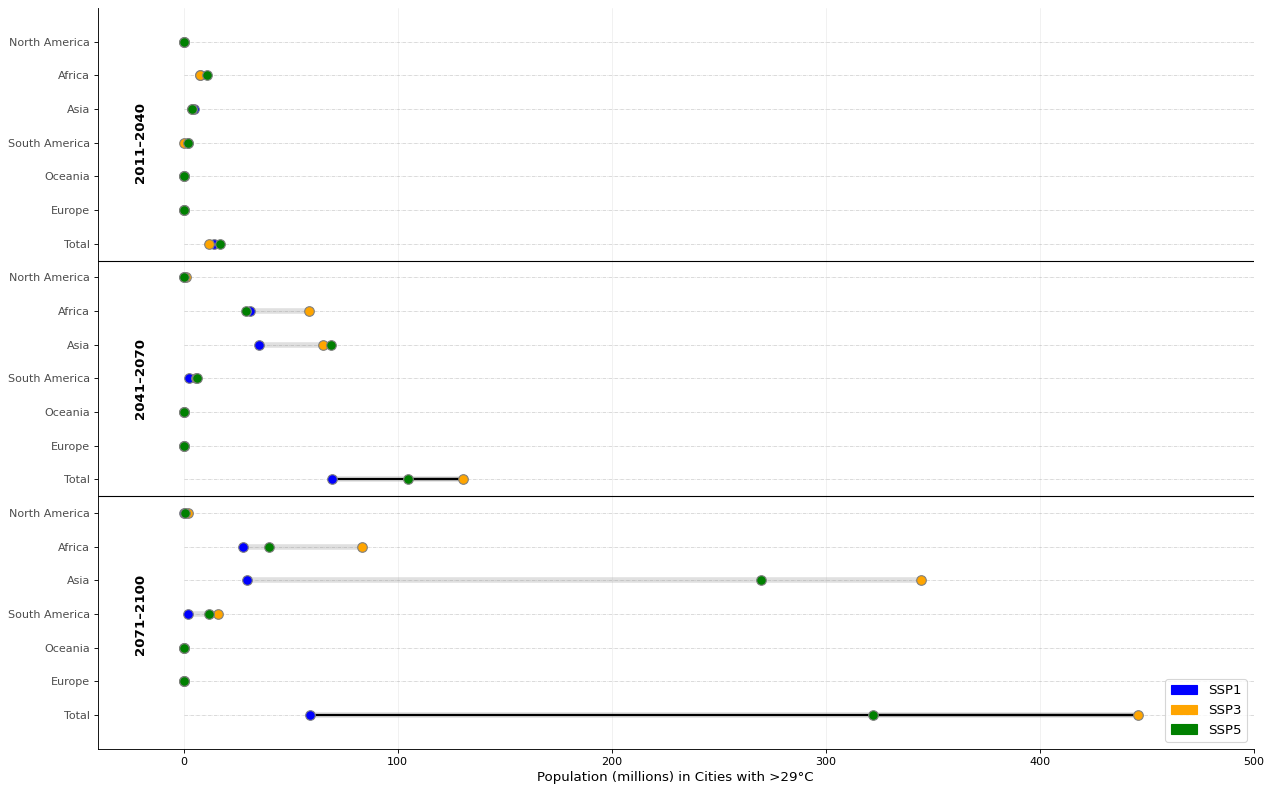

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# ----- Data Preparation -----
# Read the CSV files
csv_ssp1 = 'input_tables/final_table_over_29_SSP1.csv'
csv_ssp3 = 'input_tables/final_table_over_29_SSP3.csv'
csv_ssp5 = 'input_tables/final_table_over_29_SSP5.csv'

df_ssp1 = pd.read_csv(csv_ssp1)
df_ssp3 = pd.read_csv(csv_ssp3)
df_ssp5 = pd.read_csv(csv_ssp5)

# Function to combine dataframes for a given period suffix
def combine_scenarios(df1, df3, df5, period_suffix):
    return pd.DataFrame({
        'Continent': df1['Continent'],
        'SSP1': df1[f'Total_Pop_{period_suffix}'],
        'SSP3': df3[f'Total_Pop_{period_suffix}'],
        'SSP5': df5[f'Total_Pop_{period_suffix}']
    })

# Combine data for each time period (without totals yet)
group1 = combine_scenarios(df_ssp1, df_ssp3, df_ssp5, '2011_2040')
group2 = combine_scenarios(df_ssp1, df_ssp3, df_ssp5, '2041_2070')
group3 = combine_scenarios(df_ssp1, df_ssp3, df_ssp5, '2071_2100')

# Convert population values to millions for plotting
for df in [group1, group2, group3]:
    for col in ['SSP1', 'SSP3', 'SSP5']:
        df[col] = df[col] / 1e6

# Function to compute and append a total row for each group
def append_total_row(df):
    total = df[['SSP1', 'SSP3', 'SSP5']].sum()
    total_row = pd.DataFrame({
        'Continent': ['Total'],
        'SSP1': [total['SSP1']],
        'SSP3': [total['SSP3']],
        'SSP5': [total['SSP5']]
    })
    return pd.concat([df, total_row], ignore_index=True)

# Append the total row to each group
group1 = append_total_row(group1)
group2 = append_total_row(group2)
group3 = append_total_row(group3)

# Record the number of rows per group (each group now has original continents + 1 total row)
n1 = group1.shape[0]
n2 = group2.shape[0]
n3 = group3.shape[0]

# Concatenate the groups (earliest time frame first so that after inversion, it appears at the top)
df_all = pd.concat([group1, group2, group3], ignore_index=True)

# Compute uncertainty margin for each row (min and max across scenarios)
df_all['Uncertainty_Min'] = df_all[['SSP1', 'SSP3', 'SSP5']].min(axis=1)
df_all['Uncertainty_Max'] = df_all[['SSP1', 'SSP3', 'SSP5']].max(axis=1)

# Create y positions for each row
y_positions = np.arange(df_all.shape[0])

# We'll use the 'Continent' column for y-axis labels
ytick_labels = df_all['Continent'].tolist()

# ----- Plotting -----
fig, ax = plt.subplots(figsize=(16, 10), dpi=80)

# Draw horizontal guide lines for every row (from x=0 to 400)
ax.hlines(y=y_positions, xmin=0, xmax=500, color='gray', alpha=0.5, linewidth=0.5, linestyles='dashdot')

# Draw thicker uncertainty margin lines behind the dots (using a lighter grey)
for i, row in df_all.iterrows():
    ax.hlines(y=i, xmin=row['Uncertainty_Min'], xmax=row['Uncertainty_Max'], 
              color='lightgrey', linewidth=5, alpha=0.7, zorder=1)

# Define colors for each scenario
colors = {'SSP1': 'blue', 'SSP3': 'orange', 'SSP5': 'green'}

# Plot dots for each scenario for every row
for i, row in df_all.iterrows():
    for scenario in ['SSP1', 'SSP3', 'SSP5']:
        ax.scatter(row[scenario], i, s=75, color=colors[scenario], edgecolors='gray', zorder=3)
    # For the "Total" rows, connect the dots with a line to show the aggregated values.
    if row['Continent'] == 'Total':
        x_vals = [row['SSP1'], row['SSP3'], row['SSP5']]
        ax.plot(x_vals, [i]*3, color='black', linewidth=2, zorder=2)

# Set y-ticks to show only the continent names
ax.set_yticks(y_positions)
ax.set_yticklabels(ytick_labels, fontdict={'horizontalalignment': 'right'}, alpha=0.7)

# Invert y-axis so that the earliest group appears at the top.
ax.invert_yaxis()

# Add horizontal separator lines between the groups.
sep1 = n1 - 0.5
sep2 = n1 + n2 - 0.5
ax.axhline(y=sep1, color='black', linewidth=1)
ax.axhline(y=sep2, color='black', linewidth=1)

# Add period labels next to each group.
center_group1 = (n1 - 1) / 2
center_group2 = n1 + (n2 - 1) / 2
center_group3 = n1 + n2 + (n3 - 1) / 2
x_label = -20  # adjust x offset for period labels

ax.text(x_label, center_group1, "2011–2040", ha='center', va='center', rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group2, "2041–2070", ha='center', va='center', rotation=90, fontsize=12, fontweight='bold')
ax.text(x_label, center_group3, "2071–2100", ha='center', va='center', rotation=90, fontsize=12, fontweight='bold')

# Set x-axis label and limits
ax.set_xlabel('Population (millions) in Cities with >29°C', fontsize=12)
ax.set_xlim(-40, 500)  # extend left to show period labels

# Add title and legend
#ax.set_title('Population in Cities with >29°C by Continent and Time Period', fontsize=18)
patch_ssp1 = mpatches.Patch(color=colors['SSP1'], label='SSP1')
patch_ssp3 = mpatches.Patch(color=colors['SSP3'], label='SSP3')
patch_ssp5 = mpatches.Patch(color=colors['SSP5'], label='SSP5')
plt.legend(handles=[patch_ssp1, patch_ssp3, patch_ssp5], loc='lower right', fontsize=12)

# Remove top and right spines for a cleaner look
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Add light vertical grid lines for the x-axis
ax.grid(axis='x', alpha=0.3, linewidth=0.5)

plt.tight_layout()
plt.show()
